In [1]:
import pandas as pd

import statsmodels.api as sm
import pandas as pd
import datetime
from pathlib import Path

pd.set_option("display.max_columns", None)
# !pip install statsmodels


%config InlineBackend.figure_format = "svg"
%config InlineBackend.print_figure_kwargs = {"dpi" : 300}
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


# from cadFace.vis import percentiles_plot
import sci_palettes

try:
    sci_palettes.register_cmap()
except:
    pass
import scienceplots
from pathlib import Path
import pandas as pd
from ppp_aging.ppp_model import *
from ppp_aging.model import generate_states_cols

plt.style.use(["nature", "no-latex"])
sns.set_context("paper", font_scale=1.5)
sns.set_palette("nejm")

In [2]:
test_score = pd.read_csv("result/part2/test_score.csv")
train_score = pd.read_csv("result/part2/train_score.csv")
train_score

FileNotFoundError: [Errno 2] No such file or directory: 'result/part2/test_score.csv'

In [52]:
test_score["cad_date"] = pd.to_datetime(test_score["cad_date"])
test_score["death_date"] = pd.to_datetime(test_score["death_date"])
test_score["recuit_date"] = pd.to_datetime(test_score["recuit_date"])

train_score["cad_date"] = pd.to_datetime(train_score["cad_date"])
train_score["death_date"] = pd.to_datetime(train_score["death_date"])
train_score["recuit_date"] = pd.to_datetime(train_score["recuit_date"])

In [53]:
def add_k_year_follow(df, k=5, unit="month"):

    assert unit in ["month", "year", "day"]
    year_of_cad_after_recuit = "year_of_cad_after_recuit"
    E = f"{k}_years_cad"
    T = f"{k}_years_cad_{unit}"

    df[E] = (df[year_of_cad_after_recuit] <= k).astype(int)

    def survive_time(x):
        cad_date = x["cad_date"]
        death_date = x["death_date"]
        recuit_date = x["recuit_date"]

        if x[E] == 1:  # K年内得了冠心病
            days = (cad_date - recuit_date).days
        elif x[E] == 0:  # K年没有冠心病
            if pd.notnull(death_date):
                death_times_after_recuit = (death_date - recuit_date).days
                if death_times_after_recuit <= k * 365:  # K年内死亡了
                    days = death_times_after_recuit
                else:
                    days = k * 365  # 死亡了，但是没在k年内
            else:
                days = k * 365  # 直到隨訪結束也沒有死
        if unit == "month":
            return days / 30
        elif unit == "year":
            return days / 365
        else:
            return days

    df[T] = df.apply(survive_time, axis=1)
    return df, E, T


test_score, E_3, T_3 = add_k_year_follow(test_score, k=3)
test_score, E_5, T_5 = add_k_year_follow(test_score, k=5)
test_score, E_10, T_10 = add_k_year_follow(test_score, k=10)

In [55]:
test_score["age_bin"] = pd.cut(
    test_score["age"],
    bins=[0, 60, 65, 70],
    labels=["0-60", "60-65", "65-70"],
)

# show age bin dist
test_score.groupby(["age_bin"]).value_counts(["incident_cad"])

age_bin  incident_cad
0-60     0.0             9001
         1.0              297
60-65    0.0             3330
         1.0              279
65-70    0.0             2268
         1.0              257
dtype: int64

In [56]:
score_cols = [
    "PRS",
    "proteomicsRS",
    "SigAssocRS",
    "EnsembleProtRS",
    "PRS + RF",
    "PRS + AS",
    "SigAssocRS + RF",
    "SigAssocRS + AS",
    "SigAssocRS + RF + PRS",
    "proteomicsRS + RF",
    "proteomicsRS + AS",
    "proteomicsRS + RF + PRS",
    "EnsembleProtRS + RF",
    "EnsembleProtRS + AS",
    "EnsembleProtRS + RF + PRS",
    "RF",
    "AS",
    "RF_without_AS",
]

## 对原始分数进行calibration

In [57]:
from sklearn.calibration import (
    CalibratedClassifierCV,
    CalibrationDisplay,
    calibration_curve,
)

from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LogisticRegression


def calibration_score(raw_train_pred, raw_test_pred, train_y, method="isotonic"):
    if method == "isotonic":
        ir = IsotonicRegression(out_of_bounds="clip")
        ir.fit(raw_train_pred, train_y)

        pred_train_calibrated = ir.predict(raw_train_pred)
        pred_test_calibrated = ir.predict(raw_test_pred)
    elif method == "logitstic":
        lr = LogisticRegression(class_weight="balanced", max_iter=1000, random_state=42)
        raw_train_pred = (
            raw_train_pred.values
            if isinstance(raw_train_pred, pd.Series)
            else raw_train_pred
        )
        raw_test_pred = (
            raw_test_pred.values
            if isinstance(raw_test_pred, pd.Series)
            else raw_test_pred
        )
        lr.fit(raw_train_pred.reshape(-1, 1), train_y)
        pred_train_calibrated = lr.predict_proba(raw_train_pred.reshape(-1, 1))[:, 1]
        pred_test_calibrated = lr.predict_proba(raw_test_pred.reshape(-1, 1))[:, 1]
    else:
        raise ValueError("method should be isotonic or logitstic")

    return pred_train_calibrated, pred_test_calibrated


# method = "LR"
from scipy.stats import logistic

calibration_method = "logitstic"  # "logitstic" or "isotonic" or False


for method in score_cols:
    print(f"model: {method}, with {calibration_method} calibration")

    for_calibration_train_df = train_score[["eid", "incident_cad", method]].dropna()
    for_calibration_test_df = test_score[["eid", "incident_cad", method]].dropna()

    pred_train_calibrated, pred_test_calibrated = calibration_score(
        raw_train_pred=for_calibration_train_df[method], 
        raw_test_pred=for_calibration_test_df[method],
        train_y=for_calibration_train_df["incident_cad"],
        method=calibration_method,
    )
    # test_score[f"{method}:calibrated"] = pred_test_calibrated
    if f"{method}:calibrated" in test_score.columns:
        test_score.drop(columns=[f"{method}:calibrated"], inplace=True)

    pred_res_df = pd.DataFrame(
        {
            "eid": for_calibration_test_df.eid.reset_index(drop=True),
            f"{method}:calibrated": pred_test_calibrated,
        }
    )

    test_score = test_score.merge(pred_res_df, on="eid", how="left")


calibrated_cols = [i for i in test_score.columns if "calibrated" in i]

model: PRS, with logitstic calibration
model: proteomicsRS, with logitstic calibration
model: SigAssocRS, with logitstic calibration
model: EnsembleProtRS, with logitstic calibration
model: PRS + RF, with logitstic calibration
model: PRS + AS, with logitstic calibration
model: SigAssocRS + RF, with logitstic calibration
model: SigAssocRS + AS, with logitstic calibration
model: SigAssocRS + RF + PRS, with logitstic calibration
model: proteomicsRS + RF, with logitstic calibration
model: proteomicsRS + AS, with logitstic calibration
model: proteomicsRS + RF + PRS, with logitstic calibration
model: EnsembleProtRS + RF, with logitstic calibration
model: EnsembleProtRS + AS, with logitstic calibration
model: EnsembleProtRS + RF + PRS, with logitstic calibration
model: RF, with logitstic calibration
model: AS, with logitstic calibration
model: RF_without_AS, with logitstic calibration


In [58]:
test_score

,eid,PRS,sex,height,weight,BSA,genotype_array,age,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,assessment_center,age_squared,BMI,dbp_a,sbp_a,tc_a,tg_a,hdl_a,ldl_a,dbp,sbp,tc,tg,hdl,ldl,apob,cad,mi,crp,eGFR,Cr,CAD,cad_date,birth_date,recuit_date,death_date,cad_age,death_age,recuit_age,year_of_cad_after_recuit,survival_time,is_earily_CAD,incident_cad,cad_status,prevalent_cad,smoking,prevalent_diabetes,Arrhythmia,Stroke,Peripheral_vascular_disease,Hypertension,future_cad_time_days,future_cad_time_months,future_cad_time_years,proteomicsRS,SigAssocRS,EnsembleProtRS,PRS + RF,PRS + AS,SigAssocRS + RF,SigAssocRS + AS,SigAssocRS + RF + PRS,proteomicsRS + RF,proteomicsRS + AS,proteomicsRS + RF + PRS,EnsembleProtRS + RF,EnsembleProtRS + AS,EnsembleProtRS + RF + PRS,RF,AS,RF_without_AS,3_years_cad,3_years_cad_month,5_years_cad,5_years_cad_month,10_years_cad,10_years_cad_month,age_bin,PRS:calibrated,proteomicsRS:calibrated,SigAssocRS:calibrated,EnsembleProtRS:calibrated,PRS + RF:calibrated,PRS + AS:calibrated,SigAssocRS + RF:calibrated,SigAssocRS + AS:calibrated,SigAssocRS + RF + PRS:calibrated,proteomicsRS + RF:calibrated,proteomicsRS + AS:calibrated,proteomicsRS + RF + PRS:calibrated,EnsembleProtRS + RF:calibrated,EnsembleProtRS + AS:calibrated,EnsembleProtRS + RF + PRS:calibrated,RF:calibrated,AS:calibrated,RF_without_AS:calibrated
0,2883530.0,1.030583,1.0,171.0,64.2,1.746282,2,44.0,71.3002,-100.66700,81.855800,9.994410,-0.516576,4.576150,1.832860,5.045020,1.614310,18.488800,4,1936.0,21.9555,76.0,115.000000,5.851000,0.893000,1.635000,3.549000,76.0,115.0,5.851,0.893,1.635,3.549,1.002,0,0,0.48,112.310853,69.9,0,NaT,1965-07-01,2010-06-18,NaT,NaN,NaN,44.994521,NaN,NaN,NaN,0.0,control,0.0,0.0,0.0,0,0,0,0,5045 days 10:14:40.562038,169.0,14.0,0.067694,0.118559,0.074782,0.004710,0.043320,0.107093,0.118591,0.111727,0.066771,0.068603,0.070986,0.080357,0.076001,0.084278,-0.003829,0.039190,9.517893,0,36.5,0,60.833333,0,121.666667,0-60,0.481178,0.440299,0.611776,0.398229,0.181446,0.338494,0.567183,0.615821,0.567050,0.422962,0.439833,0.417610,0.408731,0.397874,0.405684,0.179728,0.355426,0.998093
1,2867444.0,2.192278,0.0,165.0,55.8,1.599219,2,53.0,-12.4815,3.16181,-3.999700,0.309314,-6.865420,-1.982800,-1.245250,1.828070,-4.040440,-0.823290,11,2809.0,20.4959,100.0,150.000000,7.407000,3.176000,1.415000,4.840000,100.0,150.0,7.407,3.176,1.415,4.840,1.433,0,0,1.32,82.185961,74.9,0,NaT,1955-11-01,2009-04-15,NaT,NaN,NaN,53.490411,NaN,NaN,NaN,0.0,control,0.0,0.0,0.0,0,0,0,0,5474 days 10:14:40.547041,183.0,15.0,0.034012,0.069739,0.076758,0.082868,0.087514,0.074116,0.065538,0.123503,0.042133,0.031046,0.093734,0.089410,0.078090,0.133772,0.022978,0.019502,11.872159,0,36.5,0,60.833333,0,121.666667,0-60,0.784822,0.293027,0.409230,0.407242,0.511746,0.577083,0.423405,0.393138,0.617518,0.325700,0.291151,0.514935,0.447586,0.406927,0.620584,0.268043,0.272379,0.999751
2,5869793.0,0.653794,1.0,171.0,77.3,1.916181,2,62.0,-11.4721,2.20519,0.205421,-1.035540,-2.391010,-2.383070,0.886641,-0.934631,1.414580,1.704540,9,3844.0,26.4355,81.0,144.000000,5.909000,1.869000,1.670000,3.587000,81.0,144.0,5.909,1.869,1.670,3.587,1.025,0,0,1.93,85.913239,87.7,0,NaT,1947-10-01,2010-01-19,NaT,NaN,NaN,62.345205,NaN,NaN,NaN,0.0,control,0.0,0.0,0.0,0,0,0,0,5195 days 10:14:43.101214,174.0,15.0,0.069303,0.068507,0.085926,0.054371,0.080166,0.064285,0.071763,0.051206,0.066977,0.070396,0.052764,0.085088,0.087784,0.073206,0.069679,0.103383,11.948630,0,36.5,0,60.833333,0,121.666667,60-65,0.372981,0.447855,0.404227,0.449787,0.372980,0.536871,0.381904,0.418768,0.308880,0.423816,0.447472,0.343696,0.428926,0.449665,0.359547,0.472586,0.660964,0.999767
3,4880838.0,0.664819,0.0,163.0,84.4,1.954852,2,62.0,-11.1640,3.66252,-5.106300,2.058800,0.185104,-1.089780,0.567691,-2.982090,-11.959100,-1.167040,12,3844.0,31.7663,87.0,128.000000,5.603000,1.184000,1.451221,3.394000,87.0,128.0,5.603,1.184,NaN,3.394,1.029,0,0,3.57,71.698114,80.1,0,NaT,1945-06-01,2008-05-28,NaT,NaN,NaN,63.032877,NaN,NaN,NaN,0.0,control,0.0,1.0,0

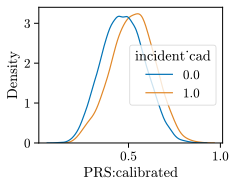

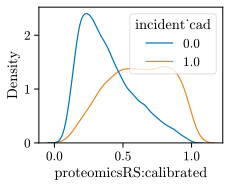

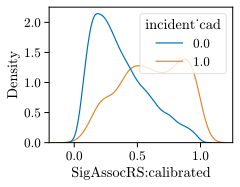

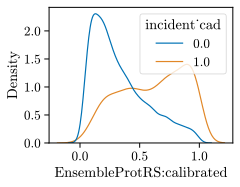

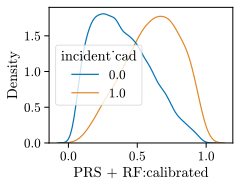

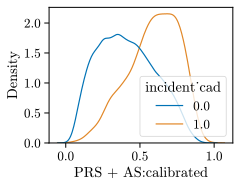

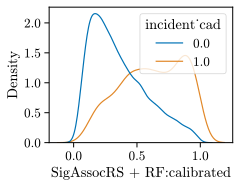

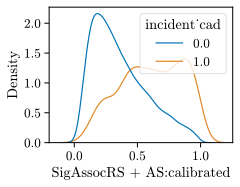

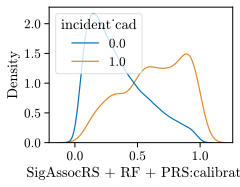

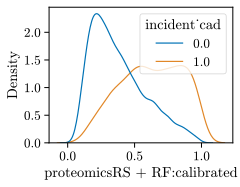

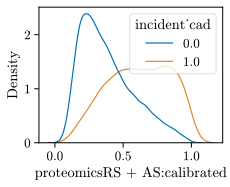

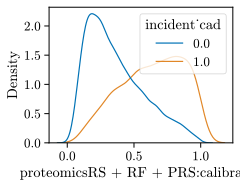

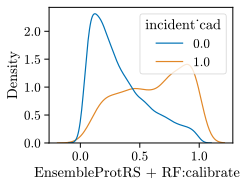

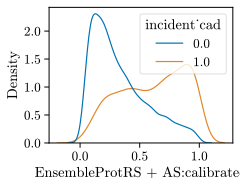

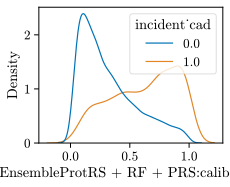

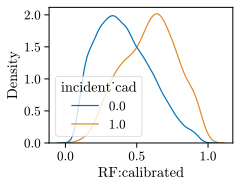

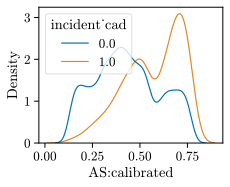

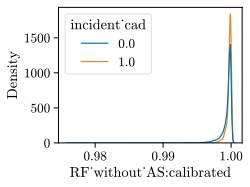

In [59]:
for col in calibrated_cols:
    fig, ax = plt.subplots()

    sns.kdeplot(
        test_score[[col, "incident_cad"]],
        x=col,
        hue="incident_cad",
        label=col,
        ax=ax,
        common_norm=False,
    )

## 百分比風險

/home/xutingfeng/ukb/project/ppp_prediction/ppp_prediction/viz.py:76: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(
/home/xutingfeng/ukb/project/ppp_prediction/ppp_prediction/viz.py:76: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(
/home/xutingfeng/ukb/project/ppp_prediction/ppp_prediction/viz.py:76: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(
/home/xutingfeng/ukb/project/ppp_prediction/ppp_prediction/viz.py:76: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(
/home/xutingfeng/ukb/pro

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

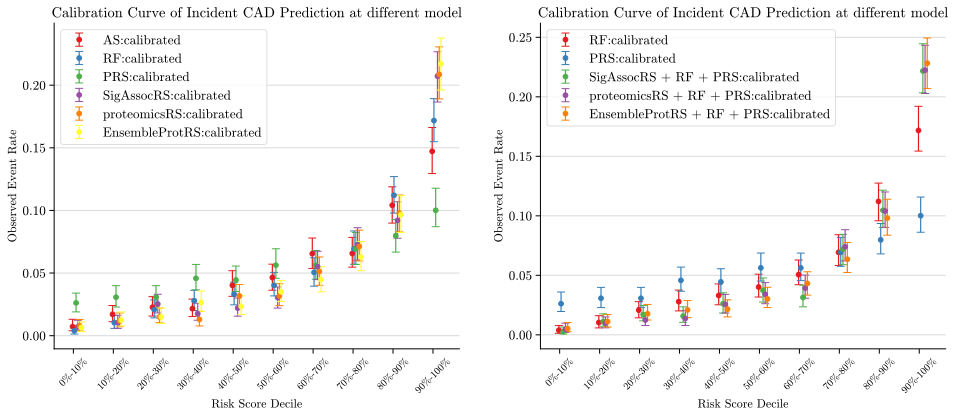

In [70]:
from ppp_prediction.viz import calibration_curve_df, calibration_dot_plot

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

## fig1
method_list = [
    "AS",
    "RF",
    "PRS",
    "SigAssocRS",
    "proteomicsRS",
    "EnsembleProtRS",
]
palletes = sns.color_palette("Set1", n_colors=len(method_list))
k = 10
tgt = "incident_cad"

plt_data = test_score[[tgt] + [f"{i}:calibrated" for i in method_list]].melt(
    value_vars=[f"{i}:calibrated" for i in method_list],
    id_vars=[tgt],
    value_name="score",
    var_name="method",
)

calibration_dot_plot(
    data=plt_data, y_true=tgt, y_pred="score", hue="method", ax=ax1, color=palletes
)
ax1.set_title(f"Calibration Curve of {tgt} Prediction with different model")


ax1.legend(loc="upper left")
# ax.legend(tgt_list)
# ax.grid(color="r", linestyle="--", linewidth=1, alpha=0.3)
ax1.yaxis.grid(color="grey", linestyle="-", linewidth=1, alpha=0.3)
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.set_xlabel("Risk Score Decile", fontsize=12)
ax1.set_ylabel("Observed Event Rate", fontsize=12)
ax1.set_title(f"Calibration Curve of Incident CAD Prediction at different model")
plt.setp(ax1.get_xticklabels(), fontsize=10, rotation=45)

## fig2
method_list = [
    "RF",
    "PRS",
    "SigAssocRS + RF + PRS",
    "proteomicsRS + RF + PRS",
    "EnsembleProtRS + RF + PRS",
]
palletes = sns.color_palette("Set1", n_colors=len(method_list))
k = 10
tgt = "incident_cad"


plt_data = test_score[[tgt] + [f"{i}:calibrated" for i in method_list]].melt(
    value_vars=[f"{i}:calibrated" for i in method_list],
    id_vars=[tgt],
    value_name="score",
    var_name="method",
)

calibration_dot_plot(
    data=plt_data, y_true=tgt, y_pred="score", hue="method", ax=ax2, color=palletes
)
ax2.set_title(f"Calibration Curve of {tgt} Prediction with different model")


ax2.legend(loc="upper left")
# ax.legend(tgt_list)
# ax.grid(color="r", linestyle="--", linewidth=1, alpha=0.3)
ax2.yaxis.grid(color="grey", linestyle="-", linewidth=1, alpha=0.3)
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
ax2.set_xlabel("Risk Score Decile", fontsize=12)
ax2.set_ylabel("Observed Event Rate", fontsize=12)
ax2.set_title(f"Calibration Curve of Incident CAD Prediction at different model")
plt.setp(ax2.get_xticklabels(), fontsize=10, rotation=45)

## 3, 5 10未来的生存分析

/home/xutingfeng/ukb/project/ppp_prediction/ppp_prediction/viz.py:76: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(
/home/xutingfeng/ukb/project/ppp_prediction/ppp_prediction/viz.py:76: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(
/home/xutingfeng/ukb/project/ppp_prediction/ppp_prediction/viz.py:76: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(
/home/xutingfeng/ukb/project/ppp_prediction/ppp_prediction/viz.py:76: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(
/home/xutingfeng/ukb/pro

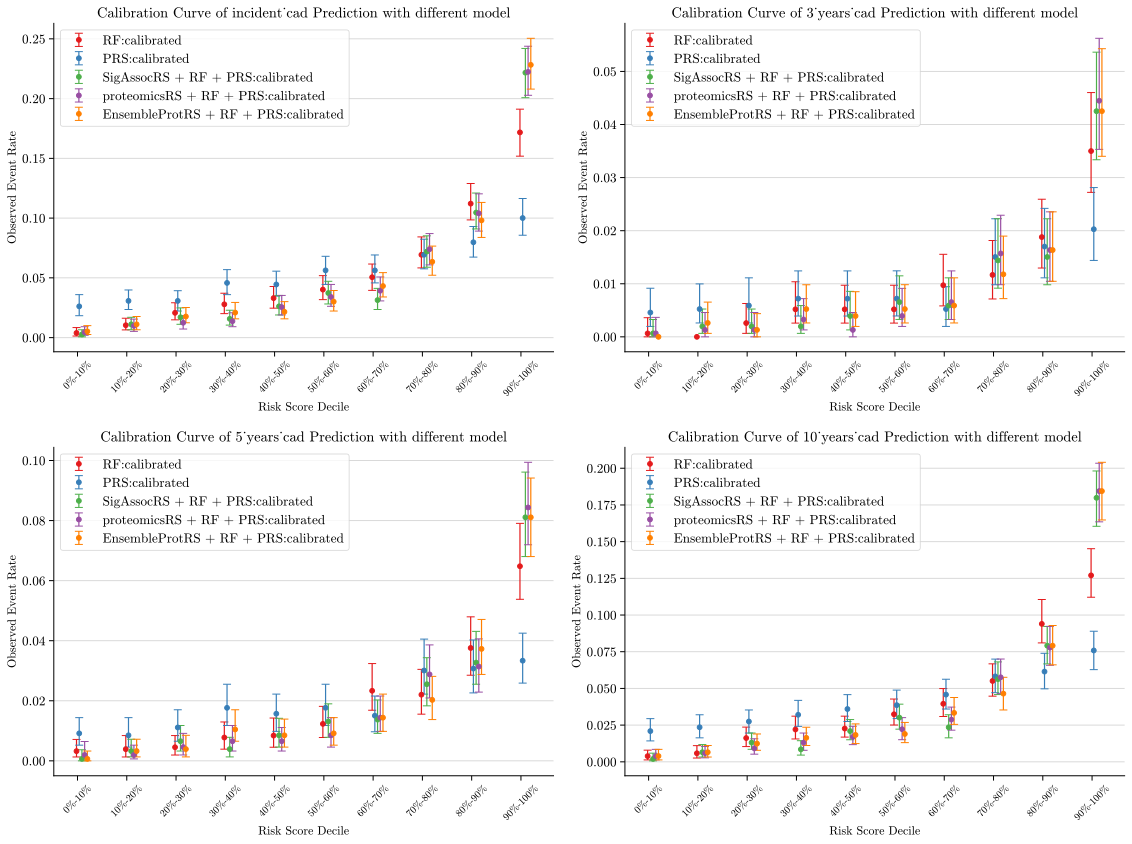

In [71]:
tgt_list = ["incident_cad", E_3, E_5, E_10]
method_list = [
    "RF",
    "PRS",
    "SigAssocRS + RF + PRS",
    "proteomicsRS + RF + PRS",
    "EnsembleProtRS + RF + PRS",
]

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()
for idx in range(len(tgt_list)):
    ax1, tgt = axes[idx], tgt_list[idx]
    plt_data = test_score[[tgt] + [f"{i}:calibrated" for i in method_list]].melt(
        value_vars=[f"{i}:calibrated" for i in method_list],
        id_vars=[tgt],
        value_name="score",
        var_name="method",
    )

    calibration_dot_plot(
        data=plt_data, y_true=tgt, y_pred="score", hue="method", ax=ax1
    )
    ax1.set_title(f"Calibration Curve of {tgt} Prediction with different model")
    plt.setp(ax1.get_xticklabels(), fontsize=10, rotation=45)
fig.tight_layout()

/home/xutingfeng/ukb/project/ppp_prediction/ppp_prediction/viz.py:76: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(
/home/xutingfeng/ukb/project/ppp_prediction/ppp_prediction/viz.py:76: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(


ValueError: Cannot cut empty array

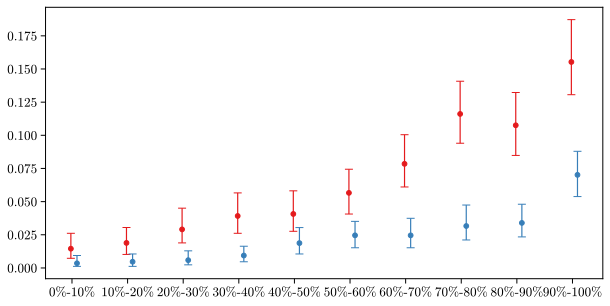

In [75]:
calibration_dot_plot(data=test_score, y_true=tgt, y_pred="RF:calibrated", hue="sex")

In [72]:
plt_data

,10_years_cad,method,score
0,0,RF:calibrated,0.179728
1,0,RF:calibrated,0.268043
2,0,RF:calibrated,0.472586
3,0,RF:calibrated,0.363689
4,0,RF:calibrated,0.370688
...,...,...,...
77155,1,EnsembleProtRS + RF + PRS:calibrated,0.960784
77156,1,EnsembleProtRS + RF + PRS:calibrated,0.259555
77157,0,EnsembleProtRS + RF + PRS:calibrated,0.676773
77158,0,EnsembleProtRS + RF + PRS:calibrated,0.203472


In [73]:
test_score

,eid,PRS,sex,height,weight,BSA,genotype_array,age,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,assessment_center,age_squared,BMI,dbp_a,sbp_a,tc_a,tg_a,hdl_a,ldl_a,dbp,sbp,tc,tg,hdl,ldl,apob,cad,mi,crp,eGFR,Cr,CAD,cad_date,birth_date,recuit_date,death_date,cad_age,death_age,recuit_age,year_of_cad_after_recuit,survival_time,is_earily_CAD,incident_cad,cad_status,prevalent_cad,smoking,prevalent_diabetes,Arrhythmia,Stroke,Peripheral_vascular_disease,Hypertension,future_cad_time_days,future_cad_time_months,future_cad_time_years,proteomicsRS,SigAssocRS,EnsembleProtRS,PRS + RF,PRS + AS,SigAssocRS + RF,SigAssocRS + AS,SigAssocRS + RF + PRS,proteomicsRS + RF,proteomicsRS + AS,proteomicsRS + RF + PRS,EnsembleProtRS + RF,EnsembleProtRS + AS,EnsembleProtRS + RF + PRS,RF,AS,RF_without_AS,3_years_cad,3_years_cad_month,5_years_cad,5_years_cad_month,10_years_cad,10_years_cad_month,age_bin,PRS:calibrated,proteomicsRS:calibrated,SigAssocRS:calibrated,EnsembleProtRS:calibrated,PRS + RF:calibrated,PRS + AS:calibrated,SigAssocRS + RF:calibrated,SigAssocRS + AS:calibrated,SigAssocRS + RF + PRS:calibrated,proteomicsRS + RF:calibrated,proteomicsRS + AS:calibrated,proteomicsRS + RF + PRS:calibrated,EnsembleProtRS + RF:calibrated,EnsembleProtRS + AS:calibrated,EnsembleProtRS + RF + PRS:calibrated,RF:calibrated,AS:calibrated,RF_without_AS:calibrated
0,2883530.0,1.030583,1.0,171.0,64.2,1.746282,2,44.0,71.3002,-100.66700,81.855800,9.994410,-0.516576,4.576150,1.832860,5.045020,1.614310,18.488800,4,1936.0,21.9555,76.0,115.000000,5.851000,0.893000,1.635000,3.549000,76.0,115.0,5.851,0.893,1.635,3.549,1.002,0,0,0.48,112.310853,69.9,0,NaT,1965-07-01,2010-06-18,NaT,NaN,NaN,44.994521,NaN,NaN,NaN,0.0,control,0.0,0.0,0.0,0,0,0,0,5045 days 10:14:40.562038,169.0,14.0,0.067694,0.118559,0.074782,0.004710,0.043320,0.107093,0.118591,0.111727,0.066771,0.068603,0.070986,0.080357,0.076001,0.084278,-0.003829,0.039190,9.517893,0,36.5,0,60.833333,0,121.666667,0-60,0.481178,0.440299,0.611776,0.398229,0.181446,0.338494,0.567183,0.615821,0.567050,0.422962,0.439833,0.417610,0.408731,0.397874,0.405684,0.179728,0.355426,0.998093
1,2867444.0,2.192278,0.0,165.0,55.8,1.599219,2,53.0,-12.4815,3.16181,-3.999700,0.309314,-6.865420,-1.982800,-1.245250,1.828070,-4.040440,-0.823290,11,2809.0,20.4959,100.0,150.000000,7.407000,3.176000,1.415000,4.840000,100.0,150.0,7.407,3.176,1.415,4.840,1.433,0,0,1.32,82.185961,74.9,0,NaT,1955-11-01,2009-04-15,NaT,NaN,NaN,53.490411,NaN,NaN,NaN,0.0,control,0.0,0.0,0.0,0,0,0,0,5474 days 10:14:40.547041,183.0,15.0,0.034012,0.069739,0.076758,0.082868,0.087514,0.074116,0.065538,0.123503,0.042133,0.031046,0.093734,0.089410,0.078090,0.133772,0.022978,0.019502,11.872159,0,36.5,0,60.833333,0,121.666667,0-60,0.784822,0.293027,0.409230,0.407242,0.511746,0.577083,0.423405,0.393138,0.617518,0.325700,0.291151,0.514935,0.447586,0.406927,0.620584,0.268043,0.272379,0.999751
2,5869793.0,0.653794,1.0,171.0,77.3,1.916181,2,62.0,-11.4721,2.20519,0.205421,-1.035540,-2.391010,-2.383070,0.886641,-0.934631,1.414580,1.704540,9,3844.0,26.4355,81.0,144.000000,5.909000,1.869000,1.670000,3.587000,81.0,144.0,5.909,1.869,1.670,3.587,1.025,0,0,1.93,85.913239,87.7,0,NaT,1947-10-01,2010-01-19,NaT,NaN,NaN,62.345205,NaN,NaN,NaN,0.0,control,0.0,0.0,0.0,0,0,0,0,5195 days 10:14:43.101214,174.0,15.0,0.069303,0.068507,0.085926,0.054371,0.080166,0.064285,0.071763,0.051206,0.066977,0.070396,0.052764,0.085088,0.087784,0.073206,0.069679,0.103383,11.948630,0,36.5,0,60.833333,0,121.666667,60-65,0.372981,0.447855,0.404227,0.449787,0.372980,0.536871,0.381904,0.418768,0.308880,0.423816,0.447472,0.343696,0.428926,0.449665,0.359547,0.472586,0.660964,0.999767
3,4880838.0,0.664819,0.0,163.0,84.4,1.954852,2,62.0,-11.1640,3.66252,-5.106300,2.058800,0.185104,-1.089780,0.567691,-2.982090,-11.959100,-1.167040,12,3844.0,31.7663,87.0,128.000000,5.603000,1.184000,1.451221,3.394000,87.0,128.0,5.603,1.184,NaN,3.394,1.029,0,0,3.57,71.698114,80.1,0,NaT,1945-06-01,2008-05-28,NaT,NaN,NaN,63.032877,NaN,NaN,NaN,0.0,control,0.0,1.0,0